In [53]:
import torch
import cv2
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
import torchvision

import matplotlib.pyplot as plt
import numpy as np

In [54]:
LABEL = 17

In [55]:
# 2. load image
im_raw = cv2.imread("cat.png")
im_np = im_raw.copy()

In [56]:
# reduce resolution
height, width, _ = im_raw.shape
im_resized = im_raw

In [57]:
# 3. Change image to tensor of given type
im_resized = torch.from_numpy(im_resized).type(torch.float32)
X = im_resized.permute(2, 0, 1)

# 4. Conver image values to range 0 to 1
Xmin = torch.min(X)
Xmax = torch.max(X)
X = X - Xmin
X = X / Xmax
X = torch.unsqueeze(X, 0)
X, X.shape

(tensor([[[[0.6588, 0.6588, 0.6588,  ..., 0.9882, 0.9882, 0.9882],
           [0.6588, 0.6588, 0.6588,  ..., 0.9882, 0.9882, 0.9882],
           [0.6588, 0.6588, 0.6588,  ..., 0.9882, 0.9882, 0.9882],
           ...,
           [0.4000, 0.4157, 0.4196,  ..., 0.9098, 0.9098, 0.9098],
           [0.3961, 0.4118, 0.4118,  ..., 0.9098, 0.9098, 0.9098],
           [0.3882, 0.4000, 0.4000,  ..., 0.9098, 0.9098, 0.9098]],
 
          [[0.7647, 0.7647, 0.7647,  ..., 0.9843, 0.9843, 0.9843],
           [0.7647, 0.7647, 0.7647,  ..., 0.9843, 0.9843, 0.9843],
           [0.7647, 0.7647, 0.7647,  ..., 0.9843, 0.9843, 0.9843],
           ...,
           [0.5059, 0.5216, 0.5255,  ..., 0.9137, 0.9137, 0.9137],
           [0.5020, 0.5176, 0.5176,  ..., 0.9137, 0.9137, 0.9137],
           [0.4941, 0.5059, 0.5059,  ..., 0.9137, 0.9137, 0.9137]],
 
          [[0.9020, 0.9020, 0.9020,  ..., 0.9882, 0.9882, 0.9882],
           [0.9020, 0.9020, 0.9020,  ..., 0.9882, 0.9882, 0.9882],
           [0.9020, 0.90

In [58]:
import onnx

onnx_model = onnx.load("../../model.onnx")
onnx.checker.check_model(onnx_model)

In [59]:
import onnxruntime as ort
import numpy as np

ort_sess = ort.InferenceSession("../../model.onnx")
outputs = ort_sess.run(None, {'input': X.cpu().numpy()})
outputs


[array([[  37.354046,   35.780735,  806.2959  ,  784.1469  ],
        [   0.      ,  549.9097  , 1000.89496 ,  840.34595 ],
        [  46.894775,  368.2151  ,  981.738   ,  804.1887  ],
        [ 154.14691 ,   33.54033 ,  617.80554 ,  575.0644  ],
        [   0.      ,   67.208176, 1145.008   ,  851.      ],
        [   0.      ,  546.78265 ,  979.8826  ,  841.70654 ]],
       dtype=float32),
 array([17, 65, 17, 17, 65, 63], dtype=int64),
 array([0.98005885, 0.6204721 , 0.41511068, 0.15064906, 0.1031038 ,
        0.06915436], dtype=float32),
 array([[[[0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.

In [60]:
mask_np = None

for i, label in enumerate(outputs[1]):
    if label == LABEL:
        mask_np = outputs[3][i]
        break

mask_np = np.transpose(mask_np, (1, 2, 0))
mask_np = cv2.resize(mask_np, (width, height))
mask_np.shape

(851, 1280)

In [61]:
mask_tensor = torch.from_numpy(mask_np)
mask_tensor = mask_tensor * Xmax
mask_tensor = mask_tensor + Xmin
mask_tensor = mask_tensor - 60
mask_tensor[mask_tensor < 0] = 0
mask_tensor[mask_tensor > 255] = 255
mask_tensor = mask_tensor.type(torch.uint8)


In [62]:
mask_np = mask_tensor.cpu().numpy()

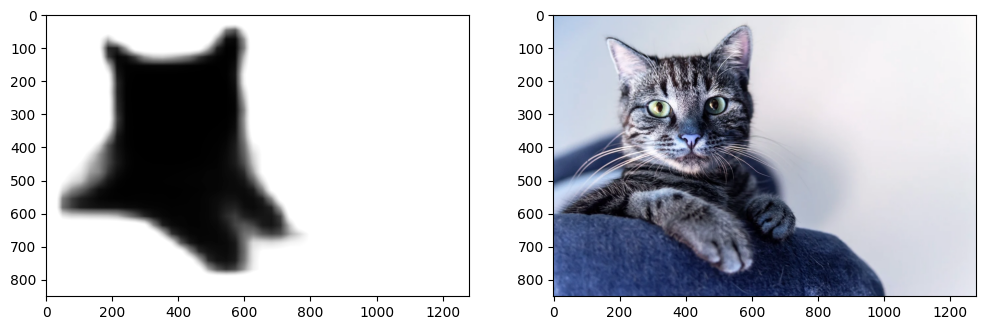

In [63]:
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.imshow(mask_np, cmap="Grays")
plt.subplot(1, 2, 2)
plt.imshow(im_np)
plt.show()

In [64]:
# 12. Get contours from the mask
contours, hierarchy = cv2.findContours(mask_np, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnt = sorted(contours, key=cv2.contourArea)[-1]

# 13. Getting proper mask from contours
mask = np.zeros((im_np.shape[0], im_np.shape[1]), dtype="uint8")
cv2.drawContours(mask, [cnt], -1, 255, -1)
mask= cv2.bitwise_not(mask)

# 14. Putting mask on the image
finalImage = cv2.bitwise_and(im_np, im_np, mask = mask)

In [65]:
# 15. Display finalImage
cv2.imshow("masked car", finalImage)
cv2.waitKey(0)
cv2.destroyAllWindows() 